# Predicting sine wave values on Arduino Nano with TensorFlow Lite

The goal of this project is to train a model that predicts values of the $\sin(x)$ function using TensorFlow. Then, we will run this model on an **Arduino Nano** board using TensorFlow Lite and use the resulting simulated function to control a blinking LED.

## <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
- [Python setup](#setup)
- [Generating data](#data)
- [Splitting data](#split)
- [Keras' Sequential model](#model)
- [Analysing model's metrics](#metrics)
- [Testing](#testing)
- [Converting the model for TensorFlow Lite](#converting)
- [Analysing lite model](#lite)
- [References](#refs)

<h2 align="center"> <font color='gray'>Python setup</font></h2> <a class="anchor" id="setup"></a>

First of all, we're going to install and import the dependencies we need. Because the text output for $\texttt{pip install}$ can be verbose, we use the $\texttt{%%capture}$ annotation to supress output.

In [1]:
%%capture
!pip install --upgrade numpy
!pip install --upgrade tensorflow

In [2]:
%%capture
import math
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-02-11 18:57:44.264456: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-11 18:57:44.334667: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 18:57:44.334738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 18:57:44.336484: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-11 18:57:44.346913: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-11 18:57:44.348337: I tensorflow/core/platform/cpu_feature_guard.cc:1

<h2 align="center"> <font color='gray'>Generating Data</font></h2> <a class="anchor" id="data"></a>

Our training data will be composed of random pairs $(x, \sin(x))$.In order to give the model complete information about the function, we will sample the period from $0$ to $2\pi$ using a uniform distribution.

It is important that the data we feed to train the model is a random order. Ordered data will decrease the model's accuracy, thus we shall shuflle the x array to ensure randomness.

To make the prediction problem more interesting, we add a random gaussian noise to our training data in order to emulate messy, real-world data.

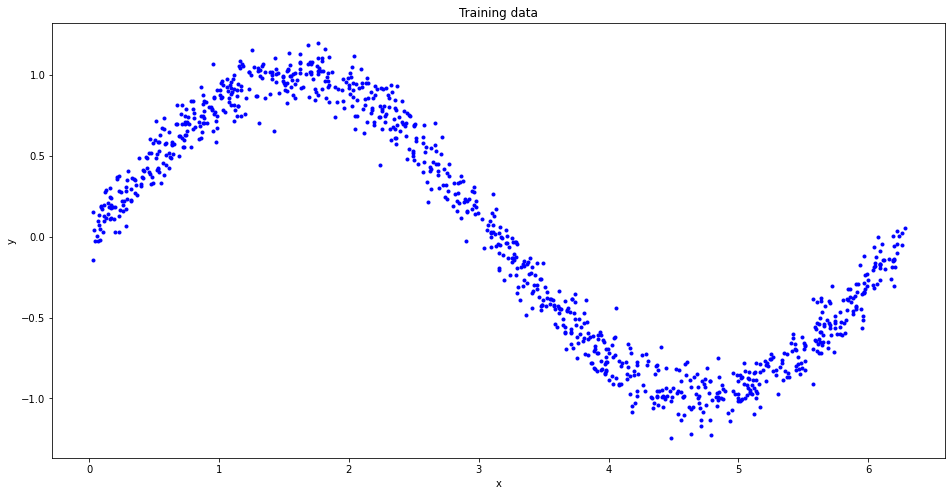

In [3]:
#size of training set
NSAMPLES = 1000
#seed for random generator
SEED = 42
#parameters for gaussian noise
MU = 0
SIGMA = 0.1

np.random.seed(SEED)
tf.random.set_seed(SEED)

#sample x values and shuffle to guarantee they're not in order
x_values = np.random.uniform(low = 0, high = 2*math.pi, size = NSAMPLES)
np.random.shuffle(x_values)

#calculate sin(x) values and add random noise
y_values = np.sin(x_values)
y_values += np.random.normal(MU, SIGMA, *y_values.shape)

plt.figure(figsize = (16, 8))
plt.plot(x_values, y_values, 'b.')
plt.title("Training data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

<h2 align="center"> <font color='gray'>Splitting data</font></h2> <a class="anchor" id="split"></a>

We are splitting our training data into three subsets: $60\%$ for *training*, $20\%$ for *validation* and $20\%$ for *testing*.

In [4]:
#we calculate the splitting indexes
TRAIN_SPLIT = int(0.6*NSAMPLES)
TEST_SPLIT = int(TRAIN_SPLIT + 0.2*NSAMPLES)

#we use np.split to divide array into 3 parts
x_train, x_validate, x_test = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_validate, y_test = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

#check that our splits add up
assert (x_train.size + x_validate.size + x_test.size) == NSAMPLES

Now, let's visualise the results of the split. Ideally, each subset should cover the entire period uniformly.

<function matplotlib.pyplot.show(close=None, block=None)>

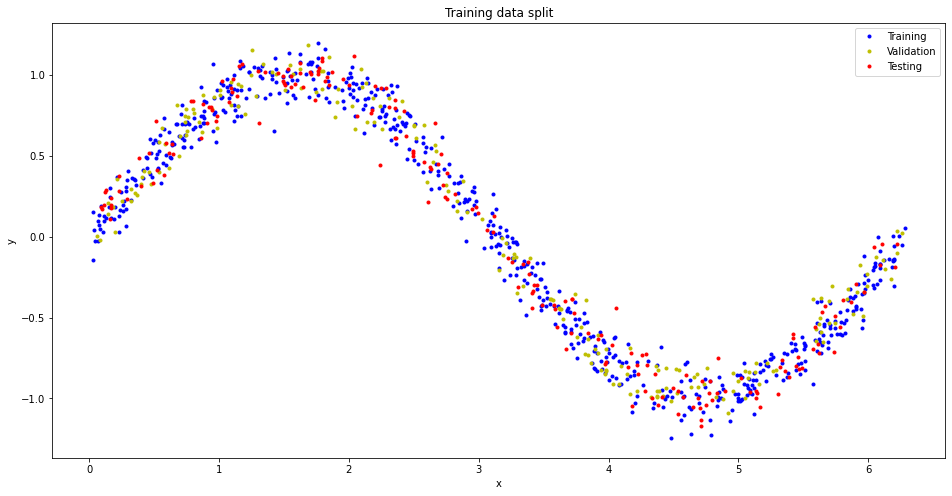

In [5]:
plt.figure(figsize = (16, 8))
plt.plot(x_train, y_train, 'b.', label='Training')
plt.plot(x_validate, y_validate, 'y.', label='Validation')
plt.plot(x_test, y_test, 'r.', label='Testing')
plt.legend()
plt.title("Training data split")
plt.xlabel("x")
plt.ylabel("y")
plt.show

<h2 align="center"> <font color='gray'>Keras' Sequential model</font></h2> <a class="anchor" id="model1"></a>

We will use *Keras*' Sequential model to design a simple neural network where each neuron layer is stacked on top of the next.

We have 3 layers: two initial layers with 16 neurons, and a final output layer with a single neuron.

In [6]:
import tensorflow.keras.layers as layers
model = tf.keras.Sequential()

#Add layers 1 and 2
model.add(layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(layers.Dense(16, activation='relu'))
#Add final output layer
model.add(layers.Dense(1))

#Compile using standar optimizer and loss function for regression
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

#Print a summary of the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now that we have defined our model, let's train it.

In [7]:
history = model.fit(x_train, y_train, epochs=1000, batch_size=16, 
                    validation_data=(x_validate, y_validate))

Epoch 1/1000
38/38 [==============================] - 1s 11ms/step - loss: 0.4185 - mae: 0.5590 - val_loss: 0.3581 - val_mae: 0.5132
Epoch 2/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.3229 - mae: 0.4837 - val_loss: 0.2958 - val_mae: 0.4692
Epoch 3/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.2664 - mae: 0.4409 - val_loss: 0.2496 - val_mae: 0.4344
Epoch 4/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.2262 - mae: 0.4089 - val_loss: 0.2173 - val_mae: 0.4106
Epoch 5/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.1974 - mae: 0.3841 - val_loss: 0.1979 - val_mae: 0.3959
Epoch 6/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.1800 - mae: 0.3670 - val_loss: 0.1939 - val_mae: 0.3805
Epoch 7/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.1731 - mae: 0.3591 - val_loss: 0.1844 - val_mae: 0.3794
Epoch 8/1000
38/38 [==============================] - 0s 5ms/step - loss: 0

38/38 [==============================] - 0s 6ms/step - loss: 0.1433 - mae: 0.2955 - val_loss: 0.1599 - val_mae: 0.3116
Epoch 63/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1419 - mae: 0.2948 - val_loss: 0.1590 - val_mae: 0.3241
Epoch 64/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1422 - mae: 0.2953 - val_loss: 0.1578 - val_mae: 0.3226
Epoch 65/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1427 - mae: 0.2956 - val_loss: 0.1579 - val_mae: 0.3125
Epoch 66/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1404 - mae: 0.2920 - val_loss: 0.1553 - val_mae: 0.3182
Epoch 67/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1440 - mae: 0.2999 - val_loss: 0.1593 - val_mae: 0.3120
Epoch 68/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1426 - mae: 0.2984 - val_loss: 0.1551 - val_mae: 0.3174
Epoch 69/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1434 -

38/38 [==============================] - 0s 5ms/step - loss: 0.1427 - mae: 0.2973 - val_loss: 0.1566 - val_mae: 0.3207
Epoch 124/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1425 - mae: 0.2964 - val_loss: 0.1556 - val_mae: 0.3144
Epoch 125/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1435 - mae: 0.2972 - val_loss: 0.1612 - val_mae: 0.3255
Epoch 126/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1424 - mae: 0.2983 - val_loss: 0.1562 - val_mae: 0.3202
Epoch 127/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1432 - mae: 0.2971 - val_loss: 0.1570 - val_mae: 0.3215
Epoch 128/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1421 - mae: 0.2947 - val_loss: 0.1555 - val_mae: 0.3144
Epoch 129/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1451 - mae: 0.2998 - val_loss: 0.1577 - val_mae: 0.3222
Epoch 130/1000
38/38 [==============================] - 0s 5ms/step - loss: 0

38/38 [==============================] - 0s 5ms/step - loss: 0.1411 - mae: 0.2914 - val_loss: 0.1554 - val_mae: 0.3151
Epoch 185/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1449 - mae: 0.2986 - val_loss: 0.1555 - val_mae: 0.3147
Epoch 186/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1409 - mae: 0.2939 - val_loss: 0.1616 - val_mae: 0.3260
Epoch 187/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1426 - mae: 0.2986 - val_loss: 0.1607 - val_mae: 0.3111
Epoch 188/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1416 - mae: 0.2954 - val_loss: 0.1589 - val_mae: 0.3115
Epoch 189/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1428 - mae: 0.2978 - val_loss: 0.1552 - val_mae: 0.3161
Epoch 190/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1428 - mae: 0.2972 - val_loss: 0.1552 - val_mae: 0.3177
Epoch 191/1000
38/38 [==============================] - 0s 5ms/step - loss: 0

38/38 [==============================] - 0s 5ms/step - loss: 0.1421 - mae: 0.2969 - val_loss: 0.1613 - val_mae: 0.3259
Epoch 246/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1404 - mae: 0.2926 - val_loss: 0.1552 - val_mae: 0.3161
Epoch 247/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1412 - mae: 0.2930 - val_loss: 0.1557 - val_mae: 0.3193
Epoch 248/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1413 - mae: 0.2936 - val_loss: 0.1563 - val_mae: 0.3204
Epoch 249/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1412 - mae: 0.2951 - val_loss: 0.1691 - val_mae: 0.3317
Epoch 250/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1451 - mae: 0.2980 - val_loss: 0.1556 - val_mae: 0.3192
Epoch 251/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1412 - mae: 0.2959 - val_loss: 0.1587 - val_mae: 0.3235
Epoch 252/1000
38/38 [==============================] - 0s 5ms/step - loss: 0

38/38 [==============================] - 0s 5ms/step - loss: 0.1434 - mae: 0.2968 - val_loss: 0.1584 - val_mae: 0.3238
Epoch 307/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1419 - mae: 0.2960 - val_loss: 0.1554 - val_mae: 0.3157
Epoch 308/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1435 - mae: 0.2964 - val_loss: 0.1586 - val_mae: 0.3240
Epoch 309/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1418 - mae: 0.2949 - val_loss: 0.1583 - val_mae: 0.3238
Epoch 310/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1416 - mae: 0.2953 - val_loss: 0.1583 - val_mae: 0.3234
Epoch 311/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1421 - mae: 0.2957 - val_loss: 0.1638 - val_mae: 0.3285
Epoch 312/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1429 - mae: 0.2971 - val_loss: 0.1552 - val_mae: 0.3181
Epoch 313/1000
38/38 [==============================] - 0s 5ms/step - loss: 0

38/38 [==============================] - 0s 5ms/step - loss: 0.1420 - mae: 0.2980 - val_loss: 0.1554 - val_mae: 0.3160
Epoch 368/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1402 - mae: 0.2953 - val_loss: 0.1552 - val_mae: 0.3182
Epoch 369/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1421 - mae: 0.2956 - val_loss: 0.1558 - val_mae: 0.3200
Epoch 370/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1424 - mae: 0.2945 - val_loss: 0.1557 - val_mae: 0.3151
Epoch 371/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1419 - mae: 0.2941 - val_loss: 0.1649 - val_mae: 0.3284
Epoch 372/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1414 - mae: 0.2961 - val_loss: 0.1553 - val_mae: 0.3159
Epoch 373/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1431 - mae: 0.2963 - val_loss: 0.1616 - val_mae: 0.3265
Epoch 374/1000
38/38 [==============================] - 0s 5ms/step - loss: 0

38/38 [==============================] - 0s 5ms/step - loss: 0.1414 - mae: 0.2960 - val_loss: 0.1557 - val_mae: 0.3195
Epoch 429/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1425 - mae: 0.2961 - val_loss: 0.1574 - val_mae: 0.3226
Epoch 430/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1404 - mae: 0.2947 - val_loss: 0.1619 - val_mae: 0.3269
Epoch 431/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1407 - mae: 0.2961 - val_loss: 0.1552 - val_mae: 0.3172
Epoch 432/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1416 - mae: 0.2964 - val_loss: 0.1581 - val_mae: 0.3233
Epoch 433/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1423 - mae: 0.2970 - val_loss: 0.1591 - val_mae: 0.3242
Epoch 434/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1387 - mae: 0.2935 - val_loss: 0.1586 - val_mae: 0.3117
Epoch 435/1000
38/38 [==============================] - 0s 5ms/step - loss: 0

38/38 [==============================] - 0s 5ms/step - loss: 0.1420 - mae: 0.2962 - val_loss: 0.1578 - val_mae: 0.3124
Epoch 490/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1394 - mae: 0.2915 - val_loss: 0.1805 - val_mae: 0.3366
Epoch 491/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1440 - mae: 0.2959 - val_loss: 0.1558 - val_mae: 0.3199
Epoch 492/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1419 - mae: 0.2952 - val_loss: 0.1553 - val_mae: 0.3160
Epoch 493/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1416 - mae: 0.2933 - val_loss: 0.1553 - val_mae: 0.3173
Epoch 494/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1410 - mae: 0.2949 - val_loss: 0.1551 - val_mae: 0.3172
Epoch 495/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1414 - mae: 0.2939 - val_loss: 0.1600 - val_mae: 0.3244
Epoch 496/1000
38/38 [==============================] - 0s 5ms/step - loss: 0

38/38 [==============================] - 0s 5ms/step - loss: 0.1410 - mae: 0.2944 - val_loss: 0.1552 - val_mae: 0.3186
Epoch 551/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1408 - mae: 0.2956 - val_loss: 0.1552 - val_mae: 0.3168
Epoch 552/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1421 - mae: 0.2952 - val_loss: 0.1552 - val_mae: 0.3166
Epoch 553/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1415 - mae: 0.2950 - val_loss: 0.1561 - val_mae: 0.3197
Epoch 554/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1422 - mae: 0.2964 - val_loss: 0.1556 - val_mae: 0.3189
Epoch 555/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1426 - mae: 0.2978 - val_loss: 0.1552 - val_mae: 0.3174
Epoch 556/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.1413 - mae: 0.2941 - val_loss: 0.1555 - val_mae: 0.3190
Epoch 557/1000
38/38 [==============================] - 0s 5ms/step - loss: 0

38/38 [==============================] - 0s 5ms/step - loss: 0.0747 - mae: 0.2027 - val_loss: 0.0786 - val_mae: 0.2137
Epoch 612/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.0713 - mae: 0.1986 - val_loss: 0.0775 - val_mae: 0.2050
Epoch 613/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.0679 - mae: 0.1926 - val_loss: 0.0723 - val_mae: 0.2077
Epoch 614/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.0644 - mae: 0.1860 - val_loss: 0.0680 - val_mae: 0.2013
Epoch 615/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.0607 - mae: 0.1807 - val_loss: 0.0651 - val_mae: 0.1878
Epoch 616/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.0583 - mae: 0.1763 - val_loss: 0.0616 - val_mae: 0.1862
Epoch 617/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.0555 - mae: 0.1718 - val_loss: 0.0586 - val_mae: 0.1797
Epoch 618/1000
38/38 [==============================] - 0s 6ms/step - loss: 0

38/38 [==============================] - 0s 6ms/step - loss: 0.0111 - mae: 0.0836 - val_loss: 0.0148 - val_mae: 0.0974
Epoch 673/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.0112 - mae: 0.0840 - val_loss: 0.0103 - val_mae: 0.0822
Epoch 674/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.0109 - mae: 0.0829 - val_loss: 0.0109 - val_mae: 0.0851
Epoch 675/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.0111 - mae: 0.0829 - val_loss: 0.0137 - val_mae: 0.0938
Epoch 676/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.0114 - mae: 0.0843 - val_loss: 0.0094 - val_mae: 0.0786
Epoch 677/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.0111 - mae: 0.0841 - val_loss: 0.0092 - val_mae: 0.0779
Epoch 678/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.0109 - mae: 0.0828 - val_loss: 0.0098 - val_mae: 0.0800
Epoch 679/1000
38/38 [==============================] - 0s 5ms/step - loss: 0

38/38 [==============================] - 0s 7ms/step - loss: 0.0104 - mae: 0.0812 - val_loss: 0.0120 - val_mae: 0.0880
Epoch 734/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.0107 - mae: 0.0826 - val_loss: 0.0130 - val_mae: 0.0908
Epoch 735/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.0104 - mae: 0.0816 - val_loss: 0.0103 - val_mae: 0.0815
Epoch 736/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.0102 - mae: 0.0802 - val_loss: 0.0202 - val_mae: 0.1092
Epoch 737/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.0104 - mae: 0.0808 - val_loss: 0.0167 - val_mae: 0.1030
Epoch 738/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.0104 - mae: 0.0811 - val_loss: 0.0097 - val_mae: 0.0802
Epoch 739/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0101 - mae: 0.0800 - val_loss: 0.0099 - val_mae: 0.0805
Epoch 740/1000
38/38 [==============================] - 0s 5ms/step - loss: 0

38/38 [==============================] - 0s 5ms/step - loss: 0.0101 - mae: 0.0802 - val_loss: 0.0101 - val_mae: 0.0808
Epoch 795/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.0100 - mae: 0.0800 - val_loss: 0.0095 - val_mae: 0.0790
Epoch 796/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.0099 - mae: 0.0803 - val_loss: 0.0100 - val_mae: 0.0807
Epoch 797/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.0103 - mae: 0.0812 - val_loss: 0.0105 - val_mae: 0.0826
Epoch 798/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.0101 - mae: 0.0807 - val_loss: 0.0195 - val_mae: 0.1098
Epoch 799/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.0103 - mae: 0.0811 - val_loss: 0.0102 - val_mae: 0.0803
Epoch 800/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.0106 - mae: 0.0819 - val_loss: 0.0173 - val_mae: 0.1033
Epoch 801/1000
38/38 [==============================] - 0s 5ms/step - loss: 0

38/38 [==============================] - 0s 4ms/step - loss: 0.0103 - mae: 0.0804 - val_loss: 0.0108 - val_mae: 0.0836
Epoch 856/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0103 - mae: 0.0805 - val_loss: 0.0093 - val_mae: 0.0785
Epoch 857/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0101 - mae: 0.0804 - val_loss: 0.0105 - val_mae: 0.0823
Epoch 858/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0103 - mae: 0.0805 - val_loss: 0.0117 - val_mae: 0.0861
Epoch 859/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0104 - mae: 0.0809 - val_loss: 0.0096 - val_mae: 0.0791
Epoch 860/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.0104 - mae: 0.0807 - val_loss: 0.0106 - val_mae: 0.0825
Epoch 861/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.0104 - mae: 0.0813 - val_loss: 0.0096 - val_mae: 0.0789
Epoch 862/1000
38/38 [==============================] - 0s 5ms/step - loss: 0

38/38 [==============================] - 0s 4ms/step - loss: 0.0101 - mae: 0.0794 - val_loss: 0.0105 - val_mae: 0.0832
Epoch 917/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0101 - mae: 0.0805 - val_loss: 0.0114 - val_mae: 0.0867
Epoch 918/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0102 - mae: 0.0799 - val_loss: 0.0098 - val_mae: 0.0798
Epoch 919/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0102 - mae: 0.0807 - val_loss: 0.0117 - val_mae: 0.0870
Epoch 920/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0099 - mae: 0.0795 - val_loss: 0.0095 - val_mae: 0.0788
Epoch 921/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0106 - mae: 0.0816 - val_loss: 0.0104 - val_mae: 0.0826
Epoch 922/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.0101 - mae: 0.0795 - val_loss: 0.0106 - val_mae: 0.0831
Epoch 923/1000
38/38 [==============================] - 0s 4ms/step - loss: 0

38/38 [==============================] - 0s 5ms/step - loss: 0.0100 - mae: 0.0796 - val_loss: 0.0097 - val_mae: 0.0795
Epoch 978/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.0105 - mae: 0.0816 - val_loss: 0.0111 - val_mae: 0.0849
Epoch 979/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.0100 - mae: 0.0801 - val_loss: 0.0096 - val_mae: 0.0792
Epoch 980/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.0101 - mae: 0.0806 - val_loss: 0.0111 - val_mae: 0.0845
Epoch 981/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.0104 - mae: 0.0804 - val_loss: 0.0105 - val_mae: 0.0832
Epoch 982/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0104 - mae: 0.0814 - val_loss: 0.0115 - val_mae: 0.0861
Epoch 983/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.0099 - mae: 0.0792 - val_loss: 0.0098 - val_mae: 0.0803
Epoch 984/1000
38/38 [==============================] - 0s 8ms/step - loss: 0

In the next section, we shall analyse these metrics in more detail, but we can already make a few observations. We observe that both *loss* and *mean absolute error* have improved during training and seem to stabilise in the final epochs.

**Our goal is to stop training when either the model is no longer improving or the training loss is less than the validation loss**. In this sense, we can consider that *number of epochs* and *batch size* seem appropriate for this case.

If we compare the evolution of loss and absolute error in the training data over epochs, we notice that

- *loss* fell from $\approx 0.42$ to $\approx 0.01$.
- *mae* fell from $\approx 0.56$ to $\approx 0.08$.

These metrics seem very promising.

<h2 align="center"> <font color='gray'>Analysing model's metrics</font></h2> <a class="anchor" id="metrics"></a>

Let's plot the evolution of the *training loss* and the *validation loss* over time. This should allow us to better interpret the results of the training and make sure our model isn't under/overfitting.

<function matplotlib.pyplot.show(close=None, block=None)>

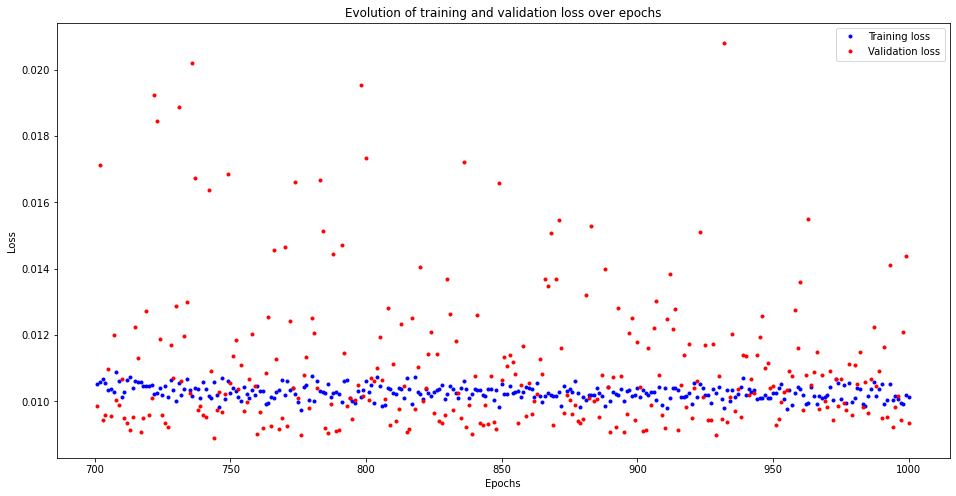

In [17]:
loss = history.history['loss']
validation_loss = history.history['val_loss']

#since loss drops rapidly in the first few epochs, let's skip ahead to get a better plot
SKIP = 700

epochs = range(1, len(loss) + 1)
plt.figure(figsize = (16, 8))
plt.plot(epochs[SKIP:], loss[SKIP:], 'b.', label = 'Training loss')
plt.plot(epochs[SKIP:], validation_loss[SKIP:], 'r.', label='Validation loss')
plt.title('Evolution of training and validation loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

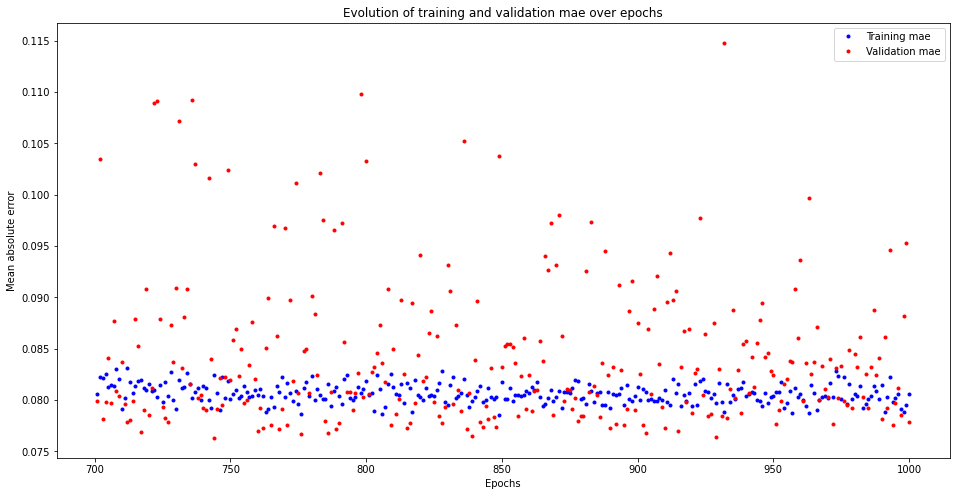

In [18]:
#we will do the same plot for the absolute error
mae = history.history['mae']
validation_mae = history.history['val_mae']

#since mae also drops rapidly in the first few epochs, let's skip ahead to get a better plot
SKIP = 700

epochs = range(1, len(loss) + 1)
plt.figure(figsize = (16, 8))
plt.plot(epochs[SKIP:], mae[SKIP:], 'b.', label = 'Training mae')
plt.plot(epochs[SKIP:], validation_mae[SKIP:], 'r.', label='Validation mae')
plt.title('Evolution of training and validation mae over epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean absolute error')
plt.legend()
plt.show

<h2 align="center"> <font color='gray'>Testing</font></h2> <a class="anchor" id="testing"></a>

7/7 [==============================] - 0s 3ms/step


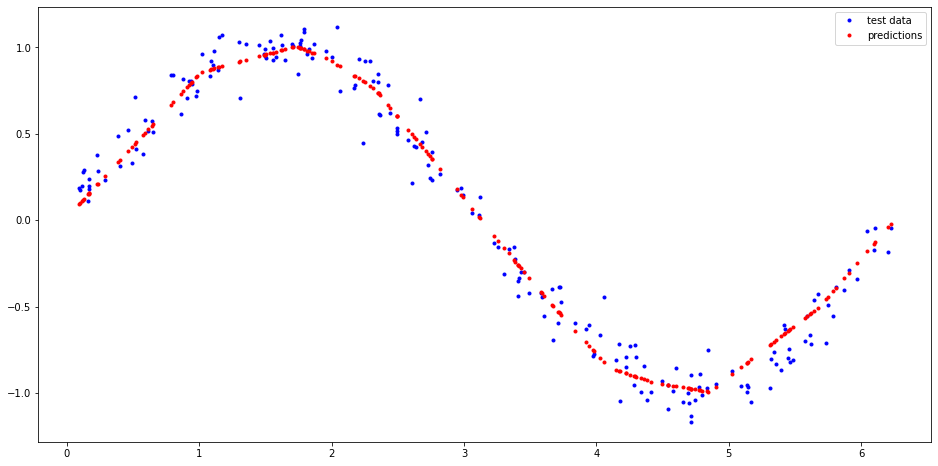

In [10]:
#evaluate loss on the test data
loss = model.evaluate(x_test, y_test)

#calculate predictions over test data for plotting
predictions = model.predict(x_test)

plt.figure(figsize=(16, 8))
plt.plot(x_test, y_test, 'b.', label='test data')
plt.plot(x_test, predictions, 'r.', label='predictions')
plt.legend()
plt.show()

We observe that the model took $4 \mathrm{ms}$ per prediction and got a *loss* of $0.0126$ which is very close to our final validation loss. We conclude that the model is predicting well and not overfitting. Despite the noise in the input data, the curve we see in the output is quite smooth.

<h2 align="center"> <font color='gray'>Converting the model for TensorFlow Lite</font></h2> <a class="anchor" id="converting"></a>

In [11]:
# convert model to TensorFlow Lite format with default optimizations (including quantization)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset_generator():
    '''we need to provide a representative dataset to allow quantization
    that means allowing operations on 8 bits in the converted model
    which reduces calculations on embedded device with minimal loss'''
    for x in x_test:
        yield [np.array(x, dtype=np.float32, ndmin=2)]
converter.representative_dataset = representative_dataset_generator

# Set quantization parameters
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Convert the model
tflite_model = converter.convert()

# Save model to disk
open("sine_model_quantized.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpd946o8ad/assets
/home/gabriel/.local/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-02-11 19:01:13.038920: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-11 19:01:13.038984: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-11 19:01:13.039623: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpd946o8ad
2024-02-11 19:01:13.041340: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-11 19:01:13.041460: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpd946o8ad
2024-02-11 19:01:13.045935: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is n

3024

The warning messages indicate that some specific operations could not be converted to the quantized format. This requires further investigation, but we observe that the *tflite* file with the converted model was successfully generated.

Let's move onto and convert the *tflite* model to a C++ file, which we will be able to load into the **Arduino Nano**'s memory.

In [12]:
#we use Unix's xxd to convert tflite file into a C++ file
!apt-get -qq install xxd

!xxd -i sine_model_quantized.tflite > sine_model_quantized.cc

E: Não foi possível abrir arquivo de trava /var/lib/dpkg/lock-frontend - open (13: Permissão negada)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


<h2 align="center"> <font color='gray'>Analysing lite model</font></h2> <a class="anchor" id="lite"></a>

In order to visualise how accurate the lite model is compared to the original, specially given the optimisations that were applied during the conversion process to reduce its computational cost, let's plot it side by side with the original model predictions.

In [13]:
#Procedure to generate predictions from TFLite model
lite_model = tf.lite.Interpreter('sine_model_quantized.tflite')
lite_model.allocate_tensors()
lite_model_input_index = lite_model.get_input_details()[0]["index"]
lite_model_output_index = lite_model.get_output_details()[0]["index"]
lite_model_predictions = []

for x in x_test:
    x_tensor = tf.convert_to_tensor([[x]], dtype=np.float32)
    lite_model.set_tensor(lite_model_input_index, x_tensor)
    lite_model.invoke()
    lite_model_predictions.append(lite_model.get_tensor(lite_model_output_index)[0])

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


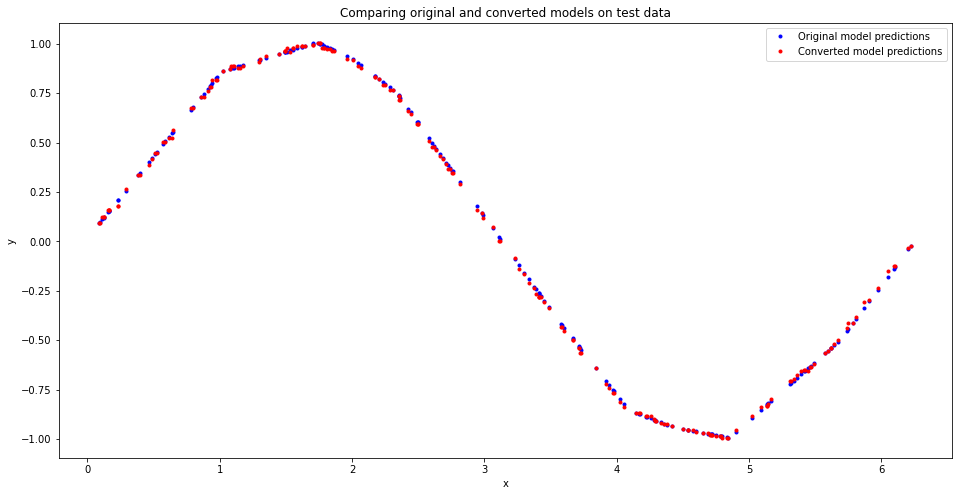

In [14]:
plt.figure(figsize=(16, 8))
plt.plot(x_test, predictions, 'b.', label='Original model predictions')
plt.plot(x_test, lite_model_predictions, 'r.', label='Converted model predictions')
plt.title('Comparing original and converted models on test data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

For the most part, we can be very happy with the results of the converted model. There is a tradeoff between precision and cost when applying the converter's optimisations, thus it is natural to observe certain discrepancies between the two curves.

<h2 align="center"> <font color='gray'>References</font></h2> <a class="anchor" id="refs"></a>

- Warden, P., & Situnayake, D. S. (2020). TinyML: Machine Learning with TensorFlow Lite on Arduino and Ultra-Low-Power Microcontrollers. O'Reilly Media.